# Variational Gaussian Process Classification (白色化あり)

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import VGP
from kernels import RBF
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
centroids = torch.rand(10, 2) * 10 - 5
X = torch.tile(centroids, (10, 1)) + torch.rand(100, 2) * 3 - 1.5
y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(X.shape[0])], dtype = torch.get_default_dtype()).unsqueeze(1)

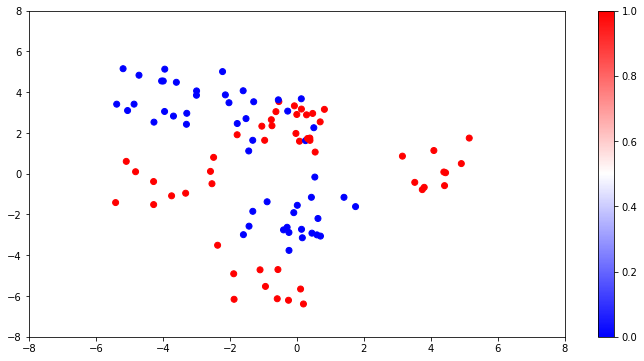

In [7]:
plt.figure(figsize = (12, 6))
plt.scatter(x = X[:, 0], y = X[:, 1], c = y[:, 0], cmap = "bwr")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.colorbar()
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

kernel = RBF()
likelihood = Binary()
estimator = VGP(X, y, kernel, likelihood, whiten = True)

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_epochs = 1000
for epoch in range(n_epochs):
    loss = svi.step()
    if epoch % (n_epochs / 10) == 0:
        print(loss)

85.91498016549812
72.14716833341777
67.51855350574075
60.33821868607589
63.32114868098236
49.03326131005022
65.20144939379713
58.56317289615481
63.990083684049665
61.90206869651962


---

## 推論結果

### 予測分布

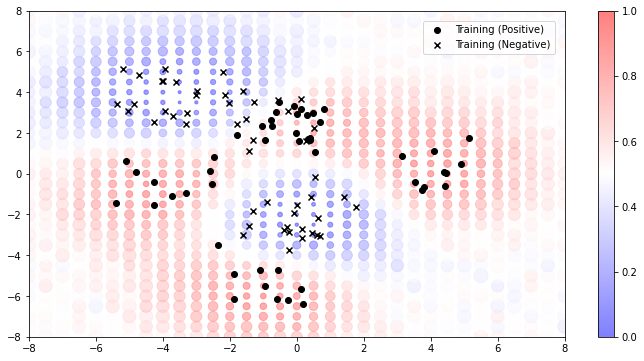

CPU times: user 549 ms, sys: 101 ms, total: 650 ms
Wall time: 456 ms


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.tensor([[x, y] for x in np.linspace(-8, 8, 33) for y in np.linspace(-8, 8, 33)], dtype = torch.get_default_dtype())
    fnew, ynew = estimator(Xnew, 100)
    pnew = torch.sigmoid(fnew)
    pnew_mean = pnew.mean(axis = 0)
    pnew_std = pnew.std(axis = 0)

    sp = pnew_std[:, 0]
    sp = ((sp - sp.min()) / sp.std()) * 50 + 1

    plt.figure(figsize = (12, 6))
    plt.scatter(
        x = Xnew[:, 0], y = Xnew[:, 1],
        s = sp,
        c = pnew_mean[:, 0], cmap = "bwr", norm = Normalize(vmin = 0, vmax = 1), alpha = 0.5,
        marker = "o"
    )
    plt.colorbar()
    plt.scatter(x = X[y[:, 0] == 1, 0], y = X[y[:, 0] == 1, 1], c = "black", marker = "o", label = "Training (Positive)")
    plt.scatter(x = X[y[:, 0] == 0, 0], y = X[y[:, 0] == 0, 1], c = "black", marker = "x", label = "Training (Negative)")
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend(bbox_to_anchor = (1, 1), loc = "upper right", borderaxespad = 1)
    plt.show()

### ハイパーパラメーター

In [10]:
estimator.kernel.scale

tensor(1.7160, grad_fn=<AddBackward0>)

### 変分パラメーター

In [11]:
estimator.f_loc

Parameter containing:
tensor([[ 3.3179e-01, -1.8688e+00,  1.4919e+00,  2.6355e-01,  7.6691e-01,
         -2.7056e-02,  7.5025e-01, -2.4088e+00,  1.2132e+00, -3.1165e-01,
         -7.4041e-01, -1.2055e+00,  5.0580e-01, -9.8448e-01,  6.3051e-01,
          2.4511e-01,  1.0219e+00, -1.0678e+00,  3.7961e-01, -7.9412e-02,
          4.0605e-01, -1.8722e-01, -8.1418e-03, -5.2311e-02,  5.4652e-01,
         -1.5506e-02,  5.2778e-01, -9.4913e-01, -7.1604e-02, -4.0526e-02,
         -1.8964e-01,  7.7350e-03,  2.1684e-01,  1.2089e-01, -6.5397e-02,
         -2.3740e-01, -4.1233e-02,  9.1786e-02, -3.2979e-02, -9.3855e-02,
          2.6202e-02, -1.1726e-01,  2.0034e-02,  1.6256e-01, -1.0499e-01,
          3.2425e-02,  1.8742e-01, -4.8168e-02, -3.2170e-02, -1.4035e-01,
          3.7662e-02,  1.4172e-02,  2.6440e-02,  1.3384e-01,  9.4657e-02,
         -2.4306e-02, -7.2710e-02, -1.0787e-01, -1.1175e-01,  1.3942e-02,
         -2.8992e-02, -3.4374e-02, -5.9125e-02, -3.6377e-02,  2.0055e-01,
         -1.4098

In [12]:
estimator.f_cov

tensor([[[ 0.1860,  0.0151,  0.0219,  ...,  0.0464,  0.0610,  0.0088],
         [ 0.0151,  0.5590, -0.0273,  ...,  0.0032,  0.0644,  0.0110],
         [ 0.0219, -0.0273,  0.6475,  ..., -0.1161, -0.0054, -0.0230],
         ...,
         [ 0.0464,  0.0032, -0.1161,  ...,  1.7104, -0.0314, -0.1488],
         [ 0.0610,  0.0644, -0.0054,  ..., -0.0314,  1.8050,  0.1242],
         [ 0.0088,  0.0110, -0.0230,  ..., -0.1488,  0.1242,  1.6151]]],
       grad_fn=<UnsafeViewBackward>)